In [120]:
import db_connect
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from scipy import stats

In [156]:
# read data
# trial with one city
earth_weather_data = db_connect.earth_weather_data()
mars_weather_data = db_connect.mars_weather_data()
solar_flares_data = db_connect.solar_flares_data()

Successfully connected to the database!
Successfully connected to the database!
Successfully connected to the database!


In [157]:
earth_weather_data.head()

,id,date,latitude,longitude,temperature_2m,relative_humidity_2m,rain,direct_radiation_instant,location
0,7090417,1990-12-27 22:00:00,63.4608,142.785,-38.165001,69.164742,0.0,0.0,London
1,7090418,1990-12-27 23:00:00,63.4608,142.785,-37.764999,68.901237,0.0,0.0,London
2,7090419,1990-12-28 00:00:00,63.4608,142.785,-36.915001,68.396278,0.0,0.0,London
3,7090420,1990-12-28 01:00:00,63.4608,142.785,-35.865002,67.254333,0.0,0.0,London
4,7090421,1990-12-28 02:00:00,63.4608,142.785,-34.915001,66.467422,0.0,0.0,London


In [158]:
earth_weather_data.date.min(), earth_weather_data.date.max()

(Timestamp('1940-01-01 07:00:00'), Timestamp('2024-03-16 23:00:00'))

In [159]:
earth_weather_data['date'] = pd.to_datetime(earth_weather_data['date'])

earth_weather_data['date'] = earth_weather_data['date'].dt.normalize()

# Group by the date and calculate the mean for each column of interest
daily_avg = earth_weather_data.groupby('date').agg({
    'latitude': 'first',
    'longitude': 'first',
    'temperature_2m': 'mean',
    'relative_humidity_2m': 'mean',
    'rain': 'mean',
    'direct_radiation_instant': 'mean',
    'location': 'first'
}).reset_index()

daily_avg.head()

,date,latitude,longitude,temperature_2m,relative_humidity_2m,rain,direct_radiation_instant,location
0,1940-01-01,25.0,13.0,-0.882934,62.495328,0.009276,114.052509,London
1,1940-01-02,25.0,13.0,-0.906817,63.525718,0.012179,109.998212,London
2,1940-01-03,25.0,13.0,-1.489750,63.139235,0.001122,115.101822,London
3,1940-01-04,25.0,13.0,-0.432378,60.449167,0.012019,98.830974,London
4,1940-01-05,25.0,13.0,0.177237,67.449696,0.124359,78.202070,London


In [189]:
daily_avg.to_parquet('data/df.parquet.gzip',compression='gzip')

In [160]:
mars_weather_data.head()

,primary_key,id,terrestrial_date,sol,ls,month,min_temp,max_temp,pressure,atmo_opacity
0,19589,1895,2018-02-27,1977,135,Month 5,-77.0,-10.0,727.0,Sunny
1,19590,1893,2018-02-26,1976,135,Month 5,-77.0,-10.0,728.0,Sunny
2,19591,1894,2018-02-25,1975,134,Month 5,-76.0,-16.0,729.0,Sunny
3,19592,1892,2018-02-24,1974,134,Month 5,-77.0,-13.0,729.0,Sunny
4,19593,1889,2018-02-23,1973,133,Month 5,-78.0,-18.0,730.0,Sunny


In [161]:
mars_weather_data.terrestrial_date.min(), mars_weather_data.terrestrial_date.max()

(Timestamp('2012-08-16 00:00:00'), Timestamp('2022-11-25 00:00:00'))

In [162]:
solar_flares_data.head()

,id,flrid,instruments,begintime,peaktime,endtime,classtype,sourcelocation,activeregionnum,note,linkedevents,submissiontime,link,intensity
0,1144,2023-10-01T01:10:00-FLR-001,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-10-01 01:10:00,2023-10-01 01:32:00,2023-10-01 01:43:00,M2.5,N12E58,13452.0,None,None,2023-10-01T14:10Z,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,Medium
1,1145,2023-10-01T01:44:00-FLR-001,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-10-01 01:44:00,2023-10-01 01:46:00,2023-10-01 01:49:00,M1.6,N15E59,13451.0,None,None,2023-10-01T01:59Z,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,Medium
2,1146,2023-10-02T12:35:00-FLR-001,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-10-02 12:35:00,2023-10-02 12:46:00,2023-10-02 12:58:00,M1.9,N19E68,13455.0,None,None,2023-10-04T15:53Z,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,Medium
3,1147,2023-10-02T15:53:00-FLR-001,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-10-02 15:53:00,2023-10-02 15:58:00,2023-10-02 16:02:00,C2.4,S17E02,13450.0,None,[{'activityID': '2023-10-02T18:24:00-CME-001'}],2023-10-03T17:19Z,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,Small
4,1148,2023-10-07T17:57:00-FLR-001,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-10-07 17:57:00,2023-10-07 18:06:00,2023-10-07 18:10:00,M1.7,S12E28,13457.0,None,None,2023-10-07T18:24Z,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,Medium


In [163]:
# Select Relevant Features:
mars_weather_data = mars_weather_data[["terrestrial_date", "min_temp", "max_temp", "pressure"]]
earth_weather_data_daily = daily_avg[["date", "temperature_2m", "relative_humidity_2m", "rain", "direct_radiation_instant"]]
solar_flares_data = solar_flares_data[["peaktime", "classtype", "intensity"]]

# Rename Columns for Consistency:
mars_weather_data.rename(columns={"terrestrial_date": "date"}, inplace=True)
solar_flares_data.rename(columns={"peaktime": "date"}, inplace=True)

In [164]:
mars_weather_data['date'] = pd.to_datetime(mars_weather_data['date']).dt.date
earth_weather_data_daily['date'] = pd.to_datetime(earth_weather_data_daily['date']).dt.date
solar_flares_data['date'] = pd.to_datetime(solar_flares_data['date'], errors = 'coerce').dt.date

C:\Users\ansam\AppData\Local\Temp\ipykernel_32016\3253603673.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [165]:
solar_flares_data.columns

Index(['date', 'classtype', 'intensity'], dtype='object')

In [166]:
# Merge DataFrames:
merged_df = pd.merge(mars_weather_data, earth_weather_data_daily, on="date", how="left")
merged_df = pd.merge(merged_df, solar_flares_data, on="date", how="left")

In [167]:
merged_df.classtype.value_counts()

classtype
M1.0    108
M1.1     88
M1.2     73
M1.3     63
M1.4     53
       ... 
C2.0      1
B8.5      1
B7.5      1
B7.2      1
B6.1      1
Name: count, Length: 199, dtype: int64

In [168]:
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date
merged_df = merged_df.sort_values('date', ascending=False)
merged_df['solar_flare'] = merged_df['classtype'].notna().astype(int)
merged_df.head()


,date,min_temp,max_temp,pressure,temperature_2m,relative_humidity_2m,rain,direct_radiation_instant,classtype,intensity,solar_flare
2079,2022-11-25,-72.0,-44.0,817.0,1.209279,62.662373,0.017949,107.730278,NaN,NaN,0
2080,2022-11-24,-72.0,-9.0,800.0,1.779150,61.529714,0.096955,97.351560,NaN,NaN,0
2081,2022-11-23,-73.0,-8.0,797.0,3.125305,61.220017,0.080929,96.340043,NaN,NaN,0
2082,2022-11-22,-72.0,-10.0,798.0,3.216731,59.682723,0.042308,111.963284,C7.0,Small,1
2083,2022-11-22,-72.0,-10.0,798.0,3.216731,59.682723,0.042308,111.963284,C4.8,Small,1


In [169]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5450 entries, 2079 to 2078
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      5450 non-null   object 
 1   min_temp                  5449 non-null   float64
 2   max_temp                  5449 non-null   float64
 3   pressure                  5450 non-null   float64
 4   temperature_2m            5450 non-null   float64
 5   relative_humidity_2m      5450 non-null   float64
 6   rain                      5450 non-null   float64
 7   direct_radiation_instant  5450 non-null   float64
 8   classtype                 1259 non-null   object 
 9   intensity                 1259 non-null   object 
 10  solar_flare               5450 non-null   int32  
dtypes: float64(7), int32(1), object(3)
memory usage: 489.6+ KB


In [170]:
merged_df['intensity'] = merged_df['intensity'].fillna('None')
merged_df['classtype'] = merged_df['classtype'].fillna('None')

In [191]:
merged_df.tail(20)

,date,min_temp,max_temp,pressure,temperature_2m,relative_humidity_2m,rain,direct_radiation_instant,classtype,intensity,solar_flare,temperature_2m_smooth
2059,2012-09-08,0.562500,0.833333,0.206278,0.807336,58.813843,0.003205,161.299413,None,None,0,0.781101
2060,2012-09-06,0.541667,0.564103,0.192825,0.804035,61.777769,0.044872,143.207505,None,None,0,0.783794
2061,2012-09-05,0.541667,0.820513,0.201794,0.852627,60.702755,0.006571,134.559424,None,None,0,0.792388
2062,2012-09-04,0.520833,0.833333,0.201794,0.829586,59.648517,0.036859,136.920584,None,None,0,0.801249
2063,2012-09-03,0.520833,0.666667,0.192825,0.793899,59.409648,0.007692,151.811408,None,None,0,0.808052
2064,2012-09-02,0.520833,0.666667,0.183857,0.774541,62.557399,0.025000,136.166256,None,None,0,0.807917
2065,2012-09-01,0.500000,0.679487,0.192825,0.801643,59.976835,0.074359,139.646827,None,None,0,0.809095
2066,2012-08-31,0.520833,0.717949,0.183857,0.793944,59.542672,0.076763,143.821035,C8.4,Small,1,0.807182
2067,2012-08-30,0.520833,0.769231,0.179372,0.828145,57.950106,0.073397,142.182245,None,None,0,0.810626
2068,2012-08-29,0.520833,0.653846,0.174888,0.832155,61.081991,0.106410,151.402620,None,None,0,0.807702


In [172]:
# Scale Data for Forecasting
scaler = MinMaxScaler()
merged_df[["min_temp", "max_temp", "pressure", "temperature_2m"]] = scaler.fit_transform(merged_df[["min_temp", "max_temp", "pressure", "temperature_2m"]])

In [186]:
# Time Series Plots:
merged_df['temperature_2m_smooth'] = merged_df['temperature_2m'].rolling(window=7).mean()

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=("Mars Min Temp", "Mars Max Temp", "Mars Pressure", "Earth Temperature"))

# Plot each variable on a separate subplot
fig.add_trace(go.Scatter(x=merged_df['date'], y=merged_df['min_temp'], name='Mars Min Temp'), row=1, col=1)
fig.add_trace(go.Scatter(x=merged_df['date'], y=merged_df['max_temp'], name='Mars Max Temp'), row=2, col=1)
fig.add_trace(go.Scatter(x=merged_df['date'], y=merged_df['pressure'], name='Mars Pressure'), row=3, col=1)
fig.add_trace(go.Scatter(x=merged_df['date'], y=merged_df['temperature_2m_smooth'], name='Earth Temperature Smoothed'), row=4, col=1)

fig.update_xaxes(title_text="Date", row=4, col=1, rangeslider_visible=True, rangeselector=dict(
    buttons=list([
        dict(count=1, label="1y", step="year", stepmode="backward"),
        dict(count=2, label="2y", step="year", stepmode="backward"),
        dict(count=5, label="5y", step="year", stepmode="backward"),
        dict(step="all")
    ])
))

# Update x-axis and y-axis labels
fig.update_xaxes(title_text="Date", row=4, col=1)  # Only the last subplot needs the x-axis label
fig.update_yaxes(title_text="Degrees C", row=1, col=1)
fig.update_yaxes(title_text="Degrees C", row=2, col=1)
fig.update_yaxes(title_text="Pressure (Pa)", row=3, col=1)
fig.update_yaxes(title_text="Degrees C", row=4, col=1)

fig.update_layout(paper_bgcolor="#000000",
                  plot_bgcolor="#000000",
                  height=1000, 
                  width=1500, 
                  title_text="Time Series of Mars and Earth Weather Data")
fig.show()

In [174]:
fig = px.scatter(merged_df, x="min_temp", y="temperature_2m_smooth", color="solar_flare",
                  title="Mars Minimum Temperature vs. Earth Temperature (Solar Flare Impact)",
                  labels={"min_temp": "Mars Min Temp", "temperature_2m": "Earth Temperature"})
fig.update_layout(paper_bgcolor="#000000",
                  plot_bgcolor="#000000",
                  height=1000, 
                  width=2000)
fig.show()

In [175]:
# Scatter Plots:
fig = px.scatter(merged_df, x="min_temp", y="temperature_2m_smooth", color="classtype",
                  title="Mars Minimum Temperature vs. Earth Temperature (Solar Flare Impact by Class Type)",
                  labels={"min_temp": "Mars Min Temp", "temperature_2m": "Earth Temperature"},
                  category_orders={"classtype": sorted(merged_df['classtype'].unique())}) 
fig.update_layout(paper_bgcolor="#000000",
                  plot_bgcolor="#000000",
                  height=1000, 
                  width=2000)
fig.show()

In [176]:
fig = px.scatter(merged_df, x="min_temp", y="temperature_2m_smooth", color="intensity",
                  title="Mars Minimum Temperature vs. Earth Temperature (Solar Flare Impact by Intensity)",
                  labels={"min_temp": "Mars Min Temp", "temperature_2m_smooth": "Earth Temperature"},
                  category_orders={"intensity": ["Low", "Medium", "High"]})  # Assuming 'Low', 'Medium', 'High' are the intensity levels
fig.update_layout(paper_bgcolor="#000000",
                  plot_bgcolor="#000000",
                  height=1000, 
                  width=2000)
fig.show()

In [188]:
# Solar Flare Impact Visualization:
fig = px.line(merged_df, x="date", y=["temperature_2m_smooth", "solar_flare"],
              title="Earth Temperature and Solar Flare Events",
              labels={"date": "Date", "temperature_2m": "Earth Temperature", "solar_flare": "Solar Flare"})

# include a range slider and range selector
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1Y", step="year", stepmode="backward"),
                dict(count=2, label="2Y", step="year", stepmode="backward"),
                dict(count=5, label="5Y", step="year", stepmode="backward"),
                dict(step="all", label="All")
            ])
        )
    ),
    paper_bgcolor="#000000",
    plot_bgcolor="#000000",
    height=1000,
    width=2000
)
fig.show()

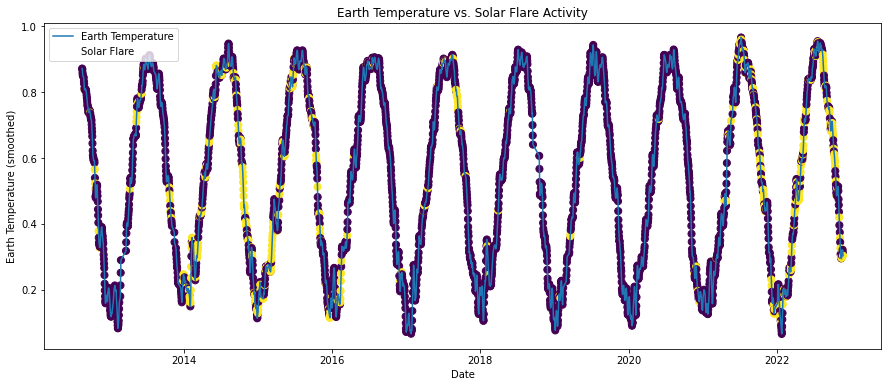

In [192]:
import matplotlib.pyplot as plt
earth_temp_daily_avg = merged_df.groupby('date')['temperature_2m'].mean().reset_index()
earth_temp_daily_avg['solar_flare'] = merged_df.groupby('date')['solar_flare'].max().reset_index()['solar_flare']
earth_temp_daily_avg['temperature_2m_smooth'] = earth_temp_daily_avg['temperature_2m'].rolling(window=7,center=True).mean()

plt.figure(figsize=(15, 6))
plt.plot(earth_temp_daily_avg['date'], earth_temp_daily_avg['temperature_2m_smooth'], label='Earth Temperature')
plt.scatter(earth_temp_daily_avg['date'], earth_temp_daily_avg['temperature_2m_smooth'], c=earth_temp_daily_avg['solar_flare'], cmap='viridis', s=50, label='Solar Flare')

plt.xlabel('Date')
plt.ylabel('Earth Temperature (smoothed)')
plt.title('Earth Temperature vs. Solar Flare Activity')
plt.legend()

plt.show()

In [200]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=earth_temp_daily_avg['date'],
    y=earth_temp_daily_avg['temperature_2m_smooth'],
    mode='lines',
    name='Earth Temperature'
))

fig.add_trace(go.Scatter(
    x=earth_temp_daily_avg['date'],
    y=earth_temp_daily_avg['temperature_2m_smooth'],
    mode='markers',
    marker=dict(
        color=earth_temp_daily_avg['solar_flare'], 
        size=10,
        showscale=True,
        colorscale='Viridis',
        colorbar=dict(
            title="Solar Flare Activity"
        )
    ),
    name='Solar Flare Activity'
))

fig.update_layout(
    title="Earth Temperature vs. Solar Flare Activity",
    xaxis_title="Date",
    yaxis_title="Earth Temperature (smoothed)",
    showlegend=True,
    legend_orientation="h",  # orientation to horizontal
    legend_x=0.5,  # center the legend horizontally
    legend_y=1.1,  # position the legend above the plot
    height=1000,
    width=2000
)

fig.show()

In [193]:
# correlation between Earth temperature and solar flare activity
correlation = earth_temp_daily_avg['temperature_2m_smooth'].corr(earth_temp_daily_avg['solar_flare'])

# Print the correlation coefficient
print(f"Correlation between Earth temperature and solar flare activity: {correlation}")

Correlation between Earth temperature and solar flare activity: -0.005750637024596126


In [178]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5450 entries, 2079 to 2078
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      5450 non-null   object 
 1   min_temp                  5449 non-null   float64
 2   max_temp                  5449 non-null   float64
 3   pressure                  5450 non-null   float64
 4   temperature_2m            5450 non-null   float64
 5   relative_humidity_2m      5450 non-null   float64
 6   rain                      5450 non-null   float64
 7   direct_radiation_instant  5450 non-null   float64
 8   classtype                 5450 non-null   object 
 9   intensity                 5450 non-null   object 
 10  solar_flare               5450 non-null   int32  
 11  temperature_2m_smooth     5444 non-null   float64
dtypes: float64(8), int32(1), object(3)
memory usage: 532.2+ KB


In [179]:
# ARIMA Model:
# Choose order (p, d, q) based on ACF/PACF plots or grid search
model = ARIMA(merged_df["temperature_2m"], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\ansam\miniconda3\envs\healthcare_ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ansam\miniconda3\envs\healthcare_ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ansam\miniconda3\envs\healthcare_ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:         temperature_2m   No. Observations:                 5450
Model:                 ARIMA(5, 1, 0)   Log Likelihood               12663.184
Date:                Mon, 20 May 2024   AIC                         -25314.368
Time:                        16:07:37   BIC                         -25274.749
Sample:                             0   HQIC                        -25300.543
                               - 5450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0403      0.013      3.033      0.002       0.014       0.066
ar.L2         -0.0161      0.011     -1.498      0.134      -0.037       0.005
ar.L3         -0.0265      0.014     -1.953      0.0

In [180]:
# Forecasting:
predictions = model_fit.predict(start=len(merged_df), end=len(merged_df)+30)
fig = px.line(merged_df, x="date", y="temperature_2m_smooth", title="Earth Temperature Forecast")
fig.add_scatter(x=merged_df["date"][-30:], y=predictions, name="Forecast")
fig.show()

c:\Users\ansam\miniconda3\envs\healthcare_ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\ansam\miniconda3\envs\healthcare_ds\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [182]:
flare_temp = merged_df[merged_df["solar_flare"] == 1]["temperature_2m"].mean()
before_flare_temp = merged_df[merged_df["solar_flare"] == 0]["temperature_2m"].mean()
after_flare_temp = merged_df[merged_df["solar_flare"] == 1]["temperature_2m"].shift(-1).fillna(method='bfill').mean()

# Perform t-test to compare temperature differences:
t_stat, p_value = stats.ttest_ind(merged_df[merged_df["solar_flare"] == 1]["temperature_2m"], 
                                 merged_df[merged_df["solar_flare"] == 0]["temperature_2m"])

print(f"Average Earth temperature during flares: {flare_temp:.2f}")
print(f"Average Earth temperature before flares: {before_flare_temp:.2f}")
print(f"Average Earth temperature after flares: {after_flare_temp:.2f}")
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.3f}")

# 2. Temporal Correlation:
#   - Calculate the correlation coefficient between Earth temperature and the occurrence of solar flares over time.
#   - Determine if there is a statistically significant correlation.
correlation = merged_df["temperature_2m"].corr(merged_df["solar_flare"])
print(f"Correlation between Earth temperature and solar flares: {correlation:.2f}")

Average Earth temperature during flares: 0.54
Average Earth temperature before flares: 0.54
Average Earth temperature after flares: 0.54
T-statistic: 0.04, P-value: 0.965
Correlation between Earth temperature and solar flares: 0.00
